In [37]:
from helpers import *
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import pickle as pkl
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from tqdm import tqdm
from datetime import datetime
import seaborn as sns
from sklearn.cluster import KMeans

pd.set_option('display.max_columns', None)

In [38]:
save_dir = ''
file_names = glob.glob(os.path.join(save_dir, f'QCEH_data/TCV_DATAno*.parquet'))

In [39]:
precomputed_dir = 'precomputed_data/'

List of dataframes (one discharge per each element of the list)

In [40]:
df_list = [pd.read_parquet(x) for x in file_names]
len(df_list)

60

# Initial Analysis - ending insights and necessary values
For this project we are only focusing on the machine inputs provided in the data.

In [41]:
GENERAL_INPUTS = ["shotnumber", "time"]
MACHINE_INPUTS = ["isbaffled", "ip","b0","nel","ptot","pdiv","q95","betan","kappa","deltaavg","deltaupp",
                  "deltalow","gapin","gapout","zmag","rmag","rmin","lpar_ot","zeff"]
LABEL = ["LHD_label"]
INPUTS = GENERAL_INPUTS + MACHINE_INPUTS + LABEL
len(INPUTS)

22

In [42]:
# This normalizes the X values.
X, y, column_names = get_training_data(include_time = False, include_shotnumber = False, shot_indices = list(range(5)))
X.shape

(55005, 19)

### Key takaways :
**data is continuous** : As such we can expect Clustering Algorithms like DBSCAN to work well

**UMAP is ideal** : It allows dimensionality reduction while maintaining clusters 

**need for shot history** : we interested is how and how long it took for a shot to reach a certain point




# Clustering

## DBSCAN

### Generate a range of values for eps 

Hyperparameter tuning is essential

We need to choose the MinPts (the min number of points per cluster), and eps the radius for neighborhood computation.

MinPts: 
In practice, a general rule of thumb is that the min cluster size is equal to 2 * #features; however it can be higher for noisy data.

eps:
The value for epsilon can be chosen using a k-distance graph, which consists in plotting the distance to the k = minPts-1 nearest neighbors (ordered)
Good values of ε are where this plot shows an "elbow"
Another way to select the epsilon is to use the silouhette score, this is what we are doing here:

In [43]:
num_features = len(column_names)
eps_values = np.linspace(0.1, 4.0, 10) #DBSCAN takes much more time for higher eps
min_pts = 2 * num_features

In [44]:
# Initialize variables to store results
best_eps = None
best_silhouette_score = -1  # Initialize with a value less than any possible silhouette score


Computing the silhouette score is quite expensive as it involves the computation of the euclidean distance between all pairs in X. (~360 min)
Also note that DBSCAN time complexity increases very quickly as eps increases.

A possible solution is to only compute this matrix once; however, if X has N samples then the distance matrix has N^2 samples which is too large for N >= 50 000

Since we have 60 shots, taking half of them is representative enough for our dataset and reduces overfitting. (would take ~90 min) but how to select a shot ?

Another solution would be to iterate through range of L shots (L per L) and then aggregate the silhouette value per epsilon to find the optimal epsilon according to the aggregated values.
This approach allow for speed efficiency, all shots consideration and avoids overfitting.

we select `L=10` as a range to enable fast computation yet generalized enough.


A custom made technique :
## L-fold Hyperparameter tuning

In [45]:
L = 10
N_SHOTS = 60
# the training data fetched is already standardized.
X_standardized_list = [
    get_training_data(
        include_time=False,
        include_shotnumber=False,
        shot_indices=list(range(i * L , i * L  + L))
    )[0] for i in range(N_SHOTS // L)
]


In [46]:
X_standardized_list[0].shape

(108670, 19)

In [47]:
# Initialize matrix to store silhouette scores
silhouette_scores = np.zeros((N_SHOTS//L,len(eps_values)))
silhouette_scores.shape

(6, 10)

In [48]:
# For simplicity of running the jupyter quickly, try loading precomputed desired silhouette scores.

try:
    with open(f"{precomputed_dir}silhouette_scores_for_{L}_per_{L}.pkl", 'rb') as f:
        silhouette_scores = pkl.load(f)
# If the desired silhouette scores does not exist, compute it.
except:
    dbscan = DBSCAN()
    # Loop over different combinations of eps and min_samples
    for j, X_standardized in tqdm(enumerate(X_standardized_list), total=N_SHOTS // L):
        for i, eps in tqdm(enumerate(eps_values), total=len(eps_values)):
            # Fit DBSCAN with current parameters
            start = datetime.now()
            dbscan = dbscan.set_params(eps=eps, min_samples=min_pts)# DBSCAN(eps=eps, min_samples=min_pts)
            labels = dbscan.fit_predict(X_standardized)
            print("DBSCAN ", datetime.now()-start)
            
            # Calculate silhouette score
            start = datetime.now()
            try:
                silhouette = silhouette_score(X_standardized, labels)
            except:
                silhouette = 0
            print("Silhouette ", datetime.now()-start)
            silhouette_scores[j, i] = silhouette  
            # Store the silhouette score
                
            # Update the best parameters if the silhouette score is higher
            if silhouette > best_silhouette_score:
                best_silhouette_score = silhouette
                best_min_pts = min_pts
                best_eps = eps
        
    # Print the best parameters
    print(f"Best eps: {best_eps}")
    print(f"Best silhouette score: {best_silhouette_score}")
    with open(f'silhouette_scores_for{L}_per_{L}.pkl', 'wb') as f:
        pkl.dump(silhouette_scores, f)


In [49]:
aggregated_silhouette_scores_mean = np.mean(silhouette_scores, axis=0)
aggregated_silhouette_scores_median = np.median(silhouette_scores, axis=0)
aggregated_silhouette_scores_median.shape

(10,)

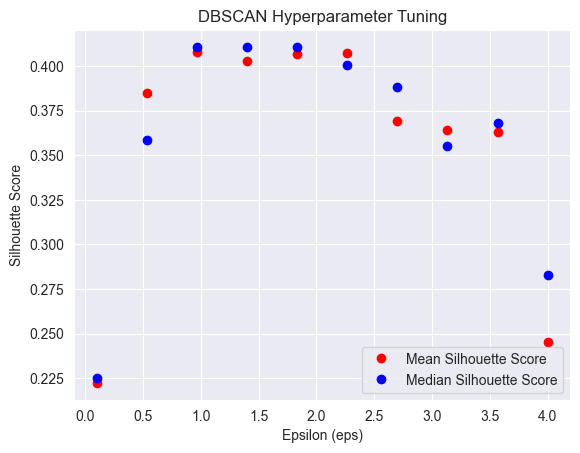

In [50]:
plt.plot(eps_values, aggregated_silhouette_scores_mean, "ro", label="Mean Silhouette Score")
plt.plot(eps_values, aggregated_silhouette_scores_median, "bo", label="Median Silhouette Score")
plt.title(f"DBSCAN Hyperparameter Tuning")
plt.xlabel("Epsilon (eps)")
plt.ylabel("Silhouette Score")
plt.legend()


In [51]:
best_mean_eps = eps_values[np.argmax(aggregated_silhouette_scores_mean)]
best_median_eps = eps_values[np.argmax(aggregated_silhouette_scores_median)]
print("best mean eps :", best_mean_eps)
print("best median eps :", best_median_eps)

best mean eps : 0.9666666666666667
best median eps : 0.9666666666666667


Ideally, we want an epsilon that yields the highest silhouette score; however, we want epsilon to be small too. So here we take the smallest epsilon which yields a high silhouette score. Here we are lucky ! since both highest silhouette with the smallest epsilon is the same, furthermore the median and mean are in accordance here. 

Theoretically everything says that we should take `eps = 0.966`.

However, upon running the next cells with this epsilon values where the score is higher than 0.375, the data becomes way to overfitted when `eps` is in `[0.966, 2.7]`. 

We also notice that the value in the score rise a bit toward 3.5 before decreasing.

This might indicate a good value which is non overfitting.
In fact, this gives us a good approximate of clusters ~20 with manual testing.

we therefore, resort to the last optimal value given by the L-fold, `3.4`


In [52]:
selected_eps = 3.4
selected_min_pts = num_features * 2 

Let's now compute DBSCAN for 5 shots :

In [53]:
dbscan = DBSCAN(eps=selected_eps, min_samples=selected_min_pts).fit(X)

labels = dbscan.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

Estimated number of clusters: 2
Estimated number of noise points: 0


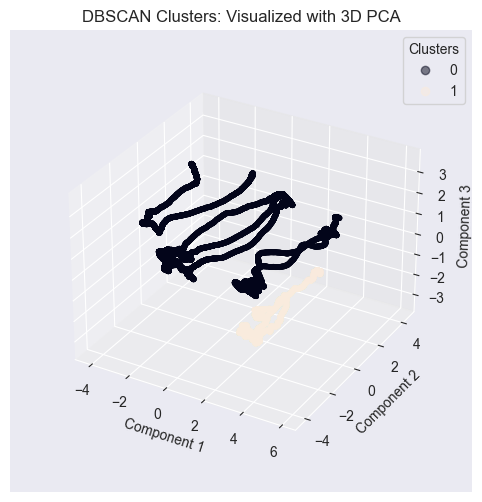

In [54]:
pca = PCA()
X_pca = pca.fit_transform(X)
draw_reduced_space(X_pca[:, :3], labels, n_components = 3, legend_labels = [0,1,2, 4, 5], legend_title ="Clusters", title = "DBSCAN Clusters: Visualized with 3D PCA")

## Analysis

Thanks to the silhouette score computation, we can say that the aggregated optimal epsilon `eps` for DBscan is theoretically `0.966`
Through these computations, we can therefore compute better DBSCAN on our data.
The above visualization and the one in the first analysis, displayed that similar shots could be regrouped and conversely separated from different ones.

This separation could allow us to regroup similar shots for further and closer inspection.

In order to enhance these agglomerations in clusters, we could also use UMAP then do the DBSCAN to see if some patterns occurs.
This would allow us to detect patterns considering all the shots, without time limitations:


## UMAP & DBSCAN
Multiple arguments proper to UMAP guide us towards it here :

- By reducing the dimensionality of the data, UMAP could improve the efficiency of DBSCAN, since the original feature space is high-dimensional. 

- UMAP is particularly good at preserving the local structure of data points in the lower-dimensional space. This is essential for algorithm such as DBSCAN that bases their logic on the neighbor search.

Also, generic ones :
- UMAP can help reduce the impact of noise features in our data.

Let's now retrieve the entire dataset :

In [55]:
complete_X, complete_y, _  = get_training_data(include_time=False, 
                                           include_shotnumber=False,
                                           shot_indices=list(range(60))
                                           )

Here is the recap of UMAP's arguments:

**n_neighbors** : represent the number of neighboring points used in local approximations. Larger values will result in more global structure being preserved. Hence, 40 is a good value since it would allow to perceive more accurately general trends within our data

**min_dist** : This controls how tightly the embedding is allowed compress points together. Smaller values allow the algorithm to optimise more accurately with regard to local structure. In this sence we select 0.1 as local structures are essential to our analysis.

**n_components** : parameter option that allows to determine the dimensionality of the reduced dimension space we will be embedding the data into. We select 10 here is order to improve efficiency while reduce noise features in our data without underfitting.

In [56]:
%%capture
try:
    with open(f'{precomputed_dir}x_umap_on_complete_data.pkl', 'rb') as f:
        X_umap = pkl.load(f)
    with open(f'{precomputed_dir}fit_umap_on_complete_data.pkl', 'rb') as f:
        umap = pkl.load(f)
except:
    umap, X_umap = perform_umap(complete_X, n_neighbors=40, min_dist=0.1, n_components=10, metric='euclidean')
    with open(f'{precomputed_dir}x_umap_on_complete_data.pkl', 'wb') as f:
        pkl.dump(X_umap,f)
    with open(f'{precomputed_dir}fit_umap_on_complete_data.pkl', 'wb') as f:
        pkl.dump(umap,f)
    


In [57]:
X_umap.shape

(624858, 10)

In [58]:
label_filename = f'{precomputed_dir}labels_dbscan_umap_eps_{selected_eps}_min_pts_{selected_min_pts}.pkl'
dbscan_fitted_filename = f'{precomputed_dir}fit_dbscan_umap_eps_{selected_eps}_min_pts_{selected_min_pts}.pkl'

try:
    with open(label_filename, 'rb') as f:
        labels = pkl.load(f)
    with open(dbscan_fitted_filename, 'rb') as f:
        dbscan = pkl.load(f)
except:
    dbscan = DBSCAN(eps=selected_eps, min_samples=selected_min_pts).fit(X_umap)
    labels = dbscan.labels_
    with open(label_filename, 'wb') as f:
        pkl.dump(labels,f)
    with open(dbscan_fitted_filename, 'wb') as f:
        pkl.dump(dbscan,f)

In [59]:
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

Estimated number of clusters: 20
Estimated number of noise points: 0


**Let's now visualize what the UMAP & DBSCAN gave us**

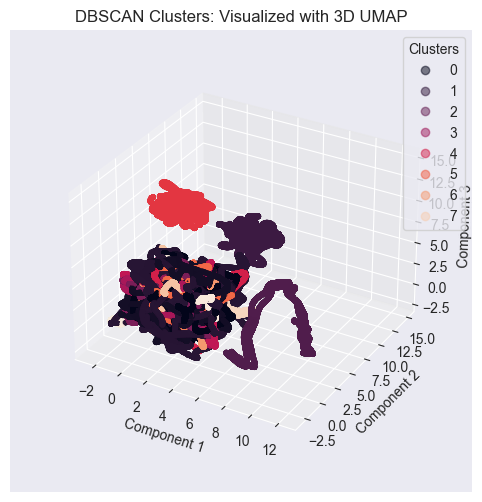

In [60]:
draw_reduced_space(X_umap[:, :3], labels, n_components = 3, legend_labels = range(n_clusters_), legend_title ="Clusters", title = "DBSCAN Clusters: Visualized with 3D UMAP")

The graph seems unclear, in order to evaluate it let's look at each cluster separately:

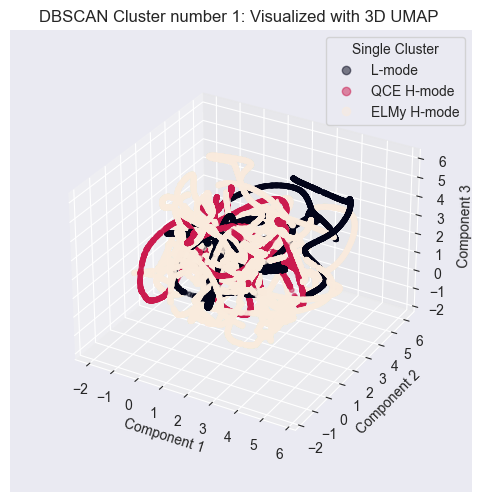

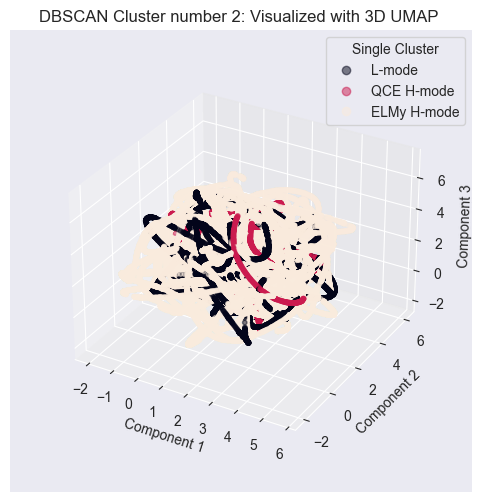

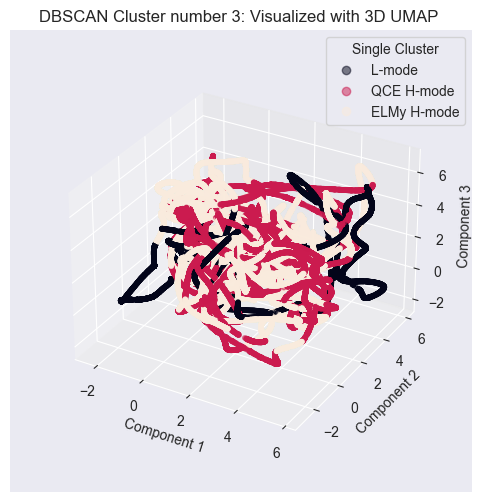

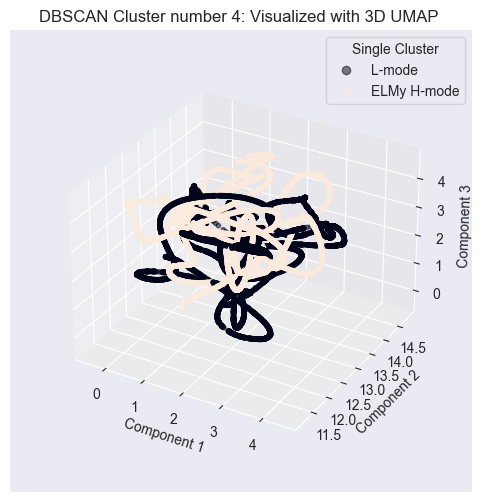

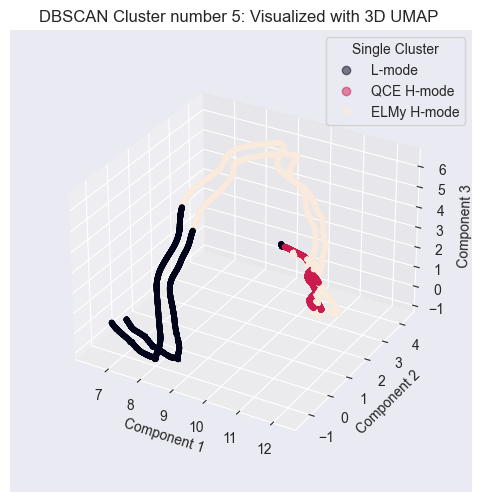

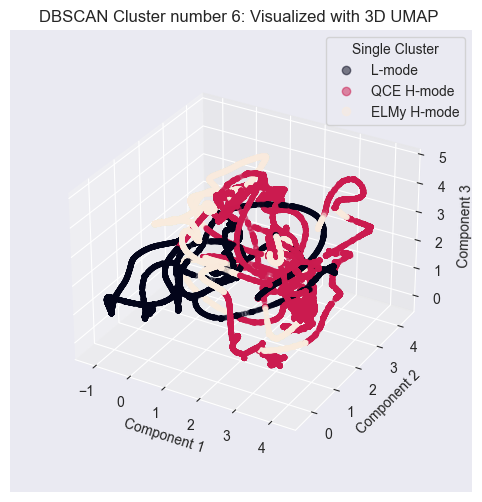

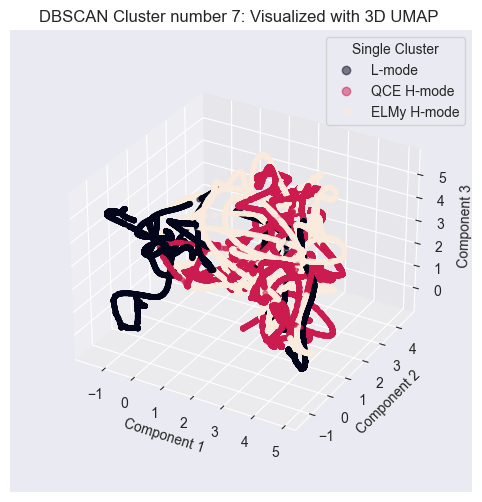

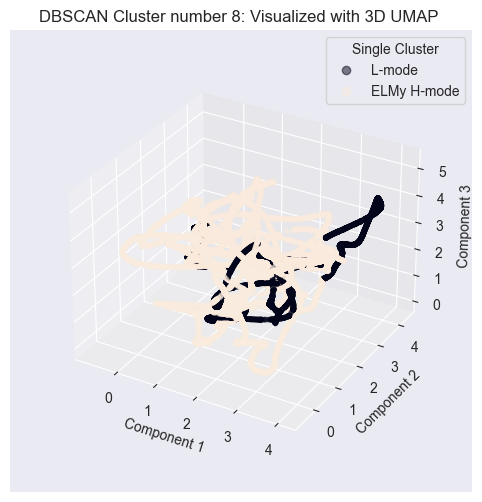

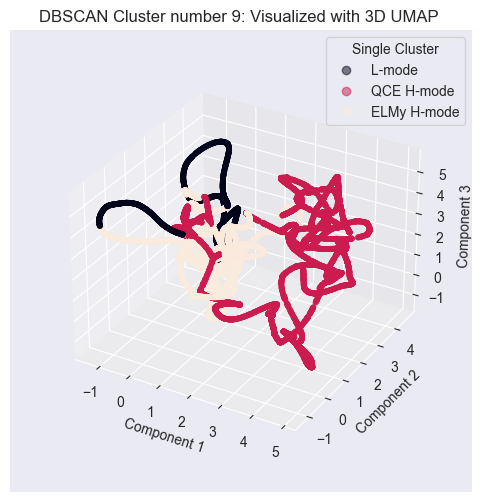

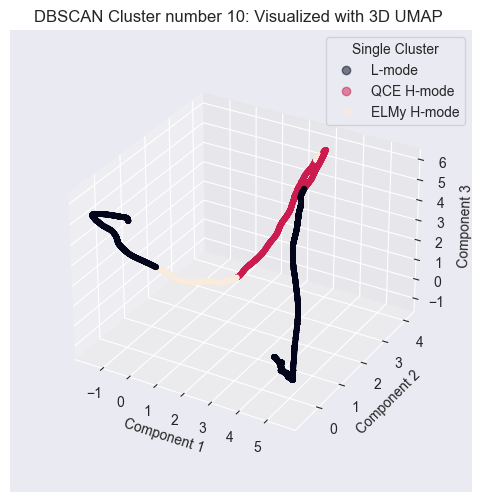

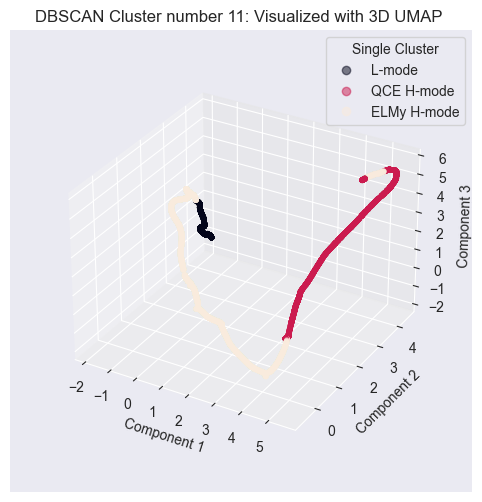

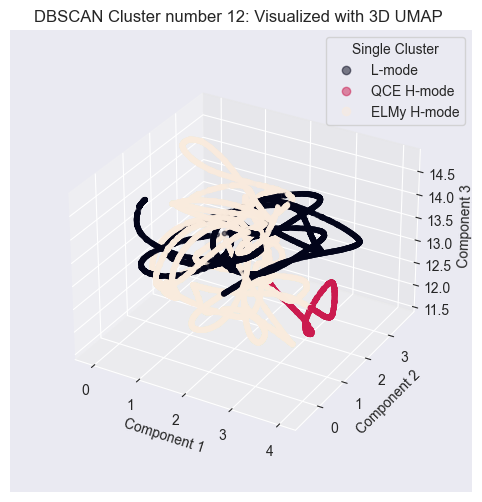

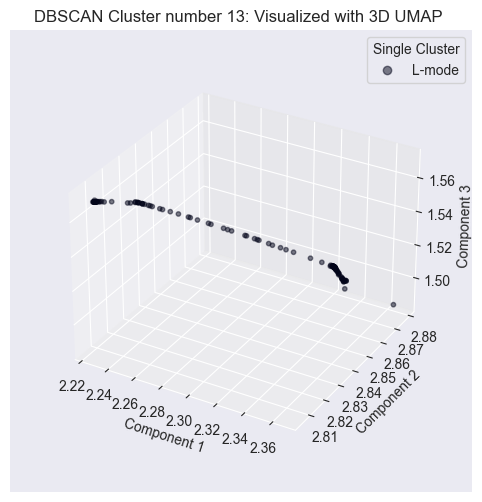

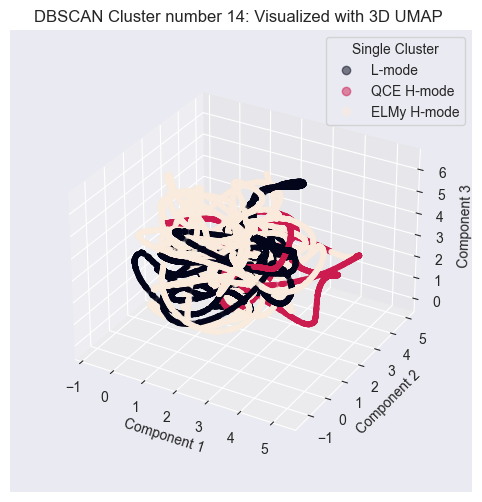

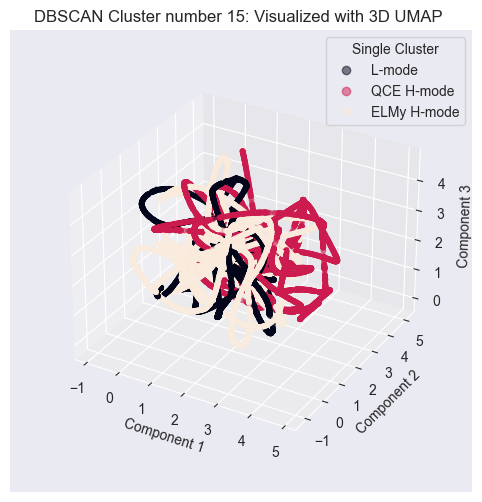

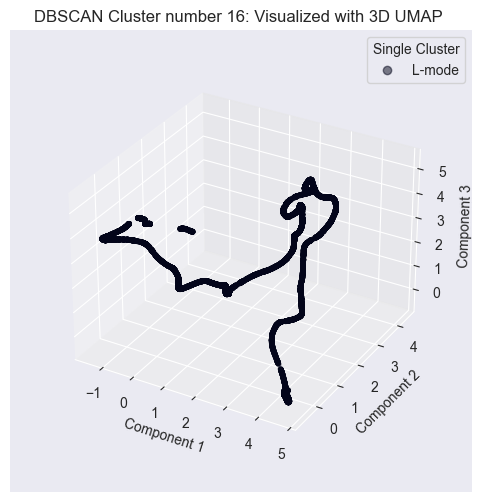

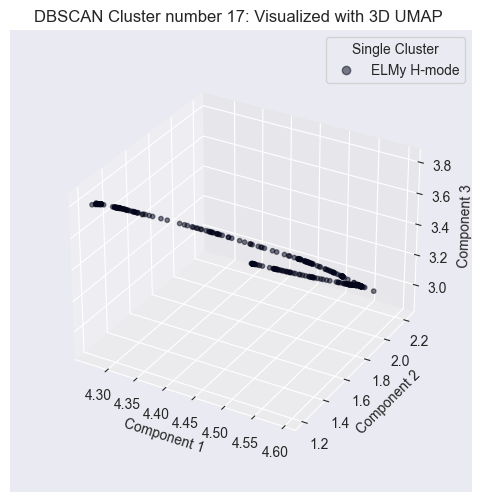

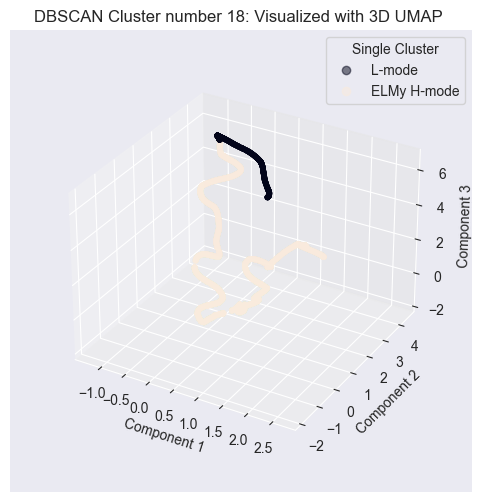

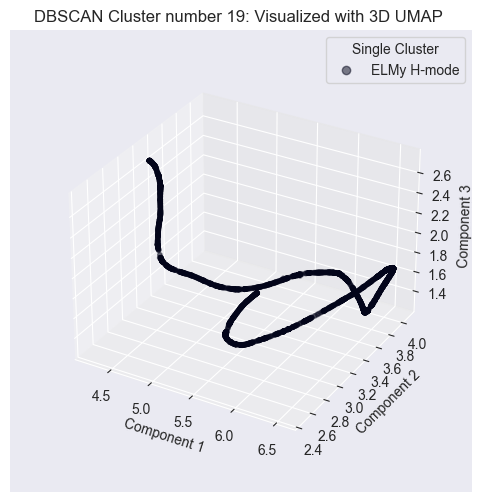

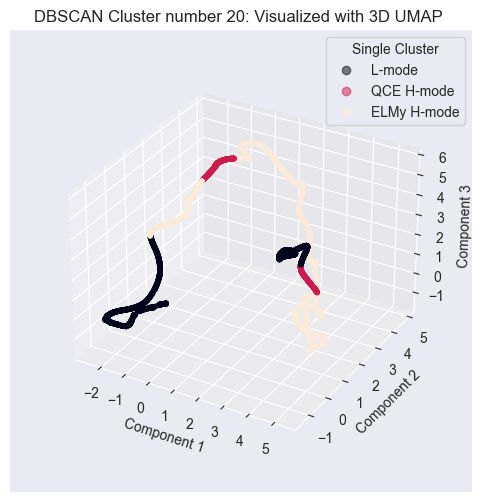

In [61]:
# Create a 3D UMAP plot for each cluster
cluster_idxs = []
for cluster_label in range(n_clusters_):
    # Filter data points belonging to the current cluster
    cluster_indices = np.where(labels == cluster_label)[0]
    cluster_idxs.append(cluster_indices)
    cluster_data = X_umap[cluster_indices]
    cluster_true_label = complete_y[cluster_indices]
    draw_reduced_space(cluster_data[:, :3], cluster_true_label, n_components = 3, legend_title ="Single Cluster", title = f"DBSCAN Cluster number {cluster_label + 1}: Visualized with 3D UMAP ")

# Analysis

 We first notice that the DBSCAN gave us 20 clusters. as a rule of thumbs, we could argue that shots where grouped by 3. Visually, this is not the case.
 
 In cluster number 5 we see that the algorithm clearly managed to identify similar shots taking the same paths, attaining one the desired goal. In contrast, we could argue that the 19 other cluster might display similar patterns in other dimensions of the 10 dimension UMAP performed.
 
 We also notice that multiple single shots or double shots are identified such as in clusters number 16 up to 20 and shots 13, 11, 10 and 5. A reason to this behavior is that these shots does not have any similarity and never intersect with any of the other displayed shots/clustered shots. This allows to regroup and distinguish quite special shots.
 
Furthermore, we can also see an imbalance in mode representation in clusters : 12, 9, 8, 6 and 4.
Where in clusters 12, 8 and 4, the QCE-H mode is clearly under-represented in favor of the two other modes, whereas in contrast cluster 6 and 9 display quite clearly shots that are more in the QCE-H state. 
exploring the intra-cluster shots could allow us to understand more what is going on there.

Hence, if it is desired to compare inter-cluster shots, it is preferable to opt for DBSCAN as argued and demonstrated previously and above.

However, since K-means allows more interpretability for  spherical data, (here our clusters), it would be useful especially to identify the average or most typical characteristics within a cluster and hence might be suitable for intra-cluster analysis.

Let's also note that K-means centroids of different DBSCAN clusters could be compared for further explorations. 

 


# Further exploration of clusters 

To detect in another point of view patterns, we will break down per cluster each feature repartition

First : 

**check** if single lines are truely single shots
**check** mode balancing in clusters
**check** what allowed these "bubbles" to regroup

## STATISTICAL ANALYSIS

In [62]:
time_and_shot_complete_X, time_and_shot_complete_y, column_names  = get_training_data(include_time=True, 
                                           include_shotnumber=True,
                                           shot_indices=list(range(60))
                                           )
time_and_shot_complete_y_reshaped = time_and_shot_complete_y.to_numpy().reshape(-1, 1)

complete_data = np.concatenate([time_and_shot_complete_X, time_and_shot_complete_y_reshaped], axis=1)



In [63]:
# Create a DataFrame for each cluster and add them to a list
dfs = []
for i, indices in enumerate(cluster_idxs):
    df = pd.DataFrame(complete_data[indices], columns=column_names)
    df['Cluster'] = i+1
    dfs.append(df)

# Combine all the DataFrames
combined_df = pd.concat(dfs)

Check Singular and dual shots :

In [64]:
single_dual_clustered_shots = [5,10,11,13] + list(range(16,21))
for i in single_dual_clustered_shots:
    print(f"for cluster {i}, there is :{combined_df[combined_df['Cluster']==i].shotnumber.drop_duplicates().count()} shots")


for cluster 5, there is :2 shots
for cluster 10, there is :1 shots
for cluster 11, there is :1 shots
for cluster 13, there is :1 shots
for cluster 16, there is :1 shots
for cluster 17, there is :1 shots
for cluster 18, there is :1 shots
for cluster 19, there is :1 shots
for cluster 20, there is :1 shots


Check mode balancing in clusters :

In [65]:
labels_mapping = {1: 'L-mode', 2: 'QCE H-mode', 3: 'ELMy H-mode'}
imbalanced_clusters = [4,6,8,9,12] 
for i in imbalanced_clusters:
    cluster_df = combined_df[combined_df['Cluster'] == i]
    total_count = len(cluster_df)
    print(f'Cluster {i} repartition:')
    for value, label in labels_mapping.items():
        label_count = (cluster_df['LHD_label'] == value).sum()
        print(f"\t {label}   \t: {label_count/total_count * 100: .2f}%")
    print('\n')
    


Cluster 4 repartition:
	 L-mode   	:  49.68%
	 QCE H-mode   	:  0.00%
	 ELMy H-mode   	:  50.32%


Cluster 6 repartition:
	 L-mode   	:  23.74%
	 QCE H-mode   	:  56.73%
	 ELMy H-mode   	:  19.53%


Cluster 8 repartition:
	 L-mode   	:  24.69%
	 QCE H-mode   	:  0.00%
	 ELMy H-mode   	:  75.31%


Cluster 9 repartition:
	 L-mode   	:  10.84%
	 QCE H-mode   	:  51.03%
	 ELMy H-mode   	:  38.13%


Cluster 12 repartition:
	 L-mode   	:  28.39%
	 QCE H-mode   	:  6.67%
	 ELMy H-mode   	:  64.94%


Understand cluster grouping :

In [66]:
desired_clusters = list(set(range(1,21)) - set(single_dual_clustered_shots))
interesting_clusters_df = combined_df[combined_df['Cluster'].isin(desired_clusters)].drop(columns=['time','LHD_label'])
desired_clusters

[1, 2, 3, 4, 6, 7, 8, 9, 12, 14, 15]

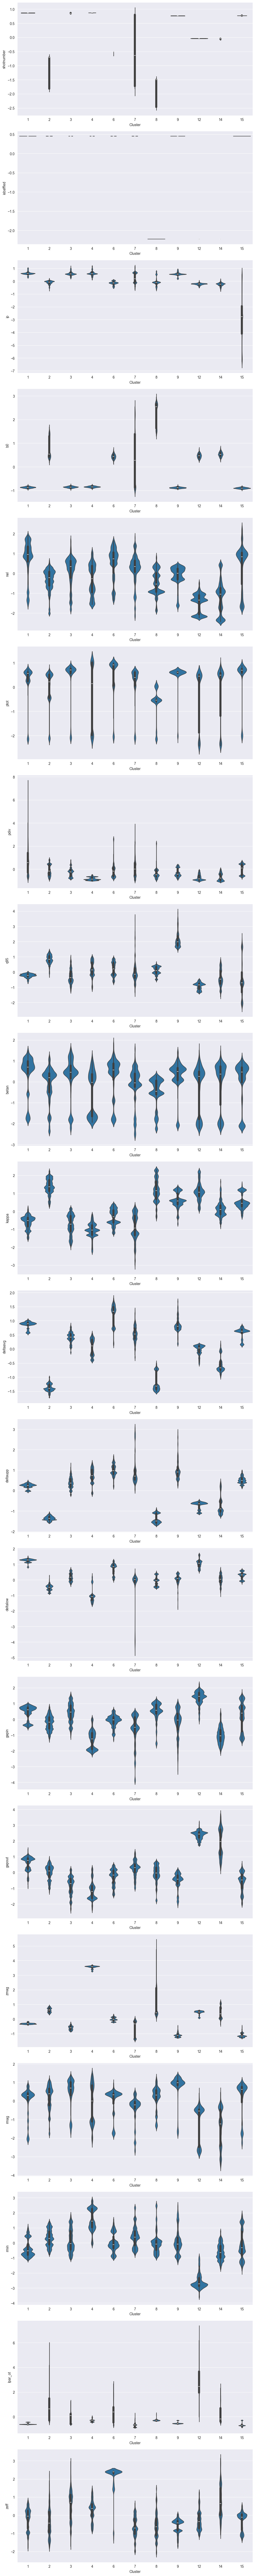

In [67]:
# Number of features to plot
num_features = interesting_clusters_df.shape[1] - 1  # excluding the cluster label column

# Create a figure with subplots
fig, axes = plt.subplots(nrows=num_features, figsize=(10, num_features * 5))

# Loop through each feature and create a violin plot
for i, col in enumerate(interesting_clusters_df.columns[:-1]):  # excluding the cluster label column
    sns.violinplot(x='Cluster', y=col, data=interesting_clusters_df, ax=axes[i])

plt.tight_layout()
plt.show()


# Analysis

From the above Violin plots per cluster, we can emit the hypothesis that the distinctive values of clusters are the reason shots are grouped within it:

**Cluster 4**, has a clearly distinctive `zmag` value of 3.5 for the median compared to the other clusters for a mean value between -1 and 1.

**Cluster 6**, has the highest `zeff` of ~2.5 for the median, hence might be what distinguish it.

**Cluster 12**, has the lowest `rmin` of -3 for the median, hence might be what distinguish a shot in cluster 12 or not.

**Cluster 9**, which exhibits the most shots in QCE-H mode, has a clear distinctive median of `q95`, around 2, compared to other clusters for which values gravitates around -1 and 1. It also displays the highest `rmag` range, with 75% quartile of 1.1 and 25% quartile of 0.9, for a median of 1.

Other clusters, does not exhibit direct and visible patterns. To observe them considering multiple at a time might be helpful. 
For example, as a result of clusters 6 and 9, it would be valuable to verify the correlation between `zeff`, `rmag` and `q95`



# Completion purposes - Kmeans:

In [68]:
# TODO improve

In [69]:

complete_X, complete_y, _ = get_training_data(include_time=False, 
                                              include_shotnumber=False,
                                              shot_indices=list(range(60)))

num_clusters = 10

# Apply K-Means clustering
kmeans = KMeans(n_clusters=7, random_state=0)
clusters = kmeans.fit_predict(X_umap)


# Your clusters are now in the 'clusters' variable


/Users/ericsaikali/Library/Mobile Documents/com~apple~CloudDocs/Documents/GitHub/tokamak-unsupervised/venv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


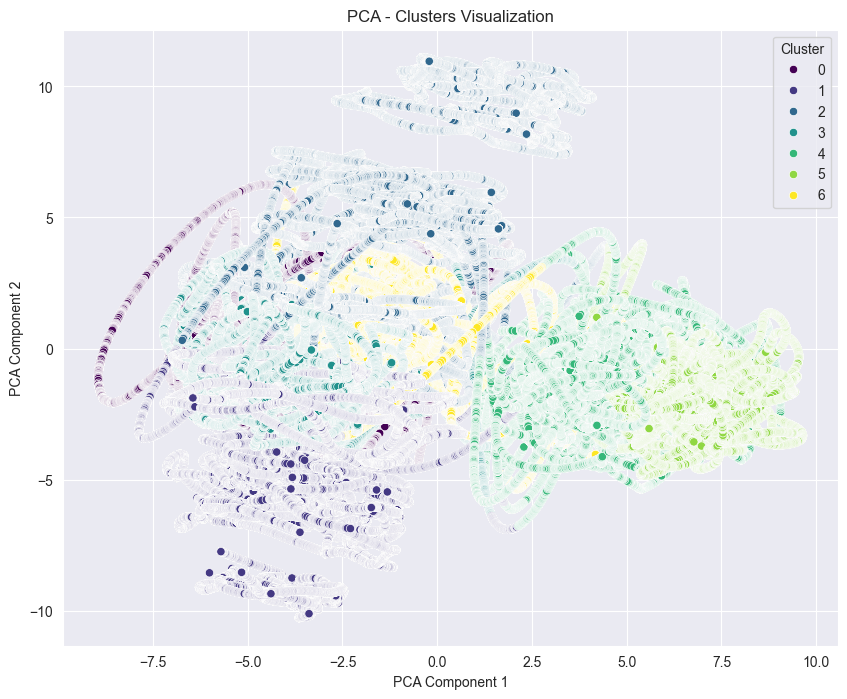

In [70]:
pca = PCA(n_components=2)  # for 2D visualization
pca_result = pca.fit_transform(X_umap)

# Create a scatter plot
plt.figure(figsize=(10, 8))
sns.scatterplot(x=pca_result[:, 0], y=pca_result[:, 1], hue=clusters, palette="viridis")

plt.title('PCA - Clusters Visualization')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster', loc='best')
plt.show()